## Load Dataset

In [ ]:
!pip install kaggle

In [ ]:
!mkdir /root/.config/kaggle
!echo "{\"username\":\"USERNAME\",\"key\":\"KEY\"}" > /root/.config/kaggle/kaggle.json
!cat /root/.config/kaggle/kaggle.json

In [ ]:
import os
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi

# API Initialization
api = KaggleApi()
api.authenticate()

# Dataset loading
competition_name = "ieee-fraud-detection"
api.competition_download_files(competition_name, path="./data")

# Extracting
with zipfile.ZipFile(f"./data/{competition_name}.zip", 'r') as zip_ref:
    zip_ref.extractall("./data")

## Necessary dependencies

In [7]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

## Imputing

In [8]:
target = None # class labels

def handle_nan_efficiently(transaction_path, identity_path, missing_threshold=0.7):
    """Handle missing values in IEEE fraud dataset efficiently"""
    global target

    # 1. Load data with optimized dtypes
    transaction = pd.read_csv(transaction_path, dtype={
        'TransactionID': 'int32',
        'TransactionDT': 'int32',
        'TransactionAmt': 'float32',
        'isFraud': 'int8'
    })


    identity = pd.read_csv(identity_path, dtype={
        'TransactionID': 'int32',
        'id_01': 'float32',
        'id_02': 'float32',
        'DeviceType': 'category',
        'DeviceInfo': 'category'
    })

    # 2. Merge datasets
    df = pd.merge(transaction, identity, on='TransactionID', how='left')
    target = df['isFraud']

    # 3. Column-wise missing value handling
    # First pass: Identify columns to drop
    cols_to_drop = [
        col for col in df.columns
        if df[col].isna().mean() > missing_threshold
    ]
    df = df.drop(columns=cols_to_drop)

    # Second pass: Handle remaining NaNs
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            # Use direct assignment instead of inplace
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            # Downcast after filling
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            # Convert to categorical and handle NaNs
            df[col] = df[col].astype('category')
            if df[col].isna().any():
                df[col] = (
                    df[col]
                    .cat.add_categories('MISSING')
                    .fillna('MISSING')
                )

    # 4. Final memory optimization
    df = df.astype({col: 'category' for col in df.select_dtypes('object').columns})
    return df

In [9]:
processed_df = handle_nan_efficiently(
        'data/train_transaction.csv',
        'data/train_identity.csv',
        missing_threshold=0.8
)

In [10]:
processed_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,361,150,discover,142,...,472,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING
1,2987001,0,86401,29.0,W,2755,404,150,mastercard,102,...,472,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING
2,2987002,0,86469,59.0,W,4663,490,150,visa,166,...,472,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING
3,2987003,0,86499,50.0,W,18132,567,150,mastercard,117,...,472,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING
4,2987004,0,86506,50.0,H,4497,514,150,mastercard,102,...,144,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


## Exploration and Preprocessing

In this part of the work, the data is examined to reveal its distribution, dependencies with each other and target variable, determine redundant features, and encode categorical features.

Workflow tools:
  1. `redundant_features` (`List(str)`): list of features that are considered to be removed.
  2. Matplotlib and Seaborn to visually understand distributions of data.
  3. Encoding of categorical data
  4. Dataset export

In [11]:
redundant_features = ['TransactionID']

### Column names and value ranges

In [12]:
for col, values in processed_df.items():
    if col.startswith('V'):
      continue
    num_uniques = values.nunique()
    print ('{name}: {num_unique}'.format(name=col, num_unique=num_uniques))
    print (values.unique())
    print ('\n')

TransactionID: 590540
[2987000 2987001 2987002 ... 3577537 3577538 3577539]


isFraud: 2
[0 1]


TransactionDT: 573349
[   86400    86401    86469 ... 15811079 15811088 15811131]


TransactionAmt: 20902
[  68.5    29.     59.   ...  557.54 1659.95  400.78]


ProductCD: 5
['W', 'H', 'C', 'S', 'R']
Categories (5, object): ['C', 'H', 'R', 'S', 'W']


card1: 13553
[13926  2755  4663 ... 13166  8767 18038]


card2: 500
[361 404 490 567 514 555 360 100 111 352 375 418 303 314 543 583 148 321
 269 272 399 569 453 417 512 545 266 114 481 452 547 383 170 343 556 285
 562 302 264 558 500 396 103 206 143 243 476 199 174 423 446 492 523 440
 528 161 535 354 117 455 325 158 268 122 479 147 215 480 265 388 408 309
 415 414 437 104 225 101 134 586 191 491 369 322 494 532 313 474 324 475
 298 429 432 553 566 599 296 251 310 242 204 250 270 346 316 194 587 390
 135 536 254 226 327 420 260 413 428 561 387 411 392 203 297 136 276 142
 527 210 184 459 118 585 106 588 449 176 177 246 439 503 445 172 468 23

### Distribution analysis

In [13]:
def visualize_distributions(df, numerical_cols=None, categorical_cols=None):
    """
    Visualize distributions of specified numerical and categorical columns.

    Parameters:
        df (pd.DataFrame): The dataset.
        numerical_cols (list): List of numerical columns to visualize.
        categorical_cols (list): List of categorical columns to visualize.
    """
    if numerical_cols:
        # Plot KDE for numerical columns
        plt.figure(figsize=(10, 5 * len(numerical_cols)))
        for i, col in enumerate(numerical_cols, 1):
            plt.subplot(len(numerical_cols), 1, i)
            sns.kdeplot(df[col], fill=True)
            plt.title(f'KDE Plot for {col}')
            plt.xlabel(col)
            plt.ylabel('Density')
        plt.tight_layout()
        plt.show()

    if categorical_cols:
        # Plot count and cumulative sum for categorical columns
        plt.figure(figsize=(10, 5 * len(categorical_cols)))
        for i, col in enumerate(categorical_cols, 1):
            plt.subplot(len(categorical_cols), 2, 2 * i - 1)
            sns.countplot(data=df, x=col, order=df[col].value_counts().index)
            plt.title(f'Count Plot for {col}')
            plt.xticks(rotation=45)

            plt.subplot(len(categorical_cols), 2, 2 * i)
            df[col].value_counts(normalize=True).cumsum().plot(kind='line', marker='o')
            plt.title(f'Cumulative Sum for {col}')
            plt.xlabel(col)
            plt.ylabel('Cumulative Proportion')
        plt.tight_layout()
        plt.show()

### Study of transaction amount, distance, card and product information

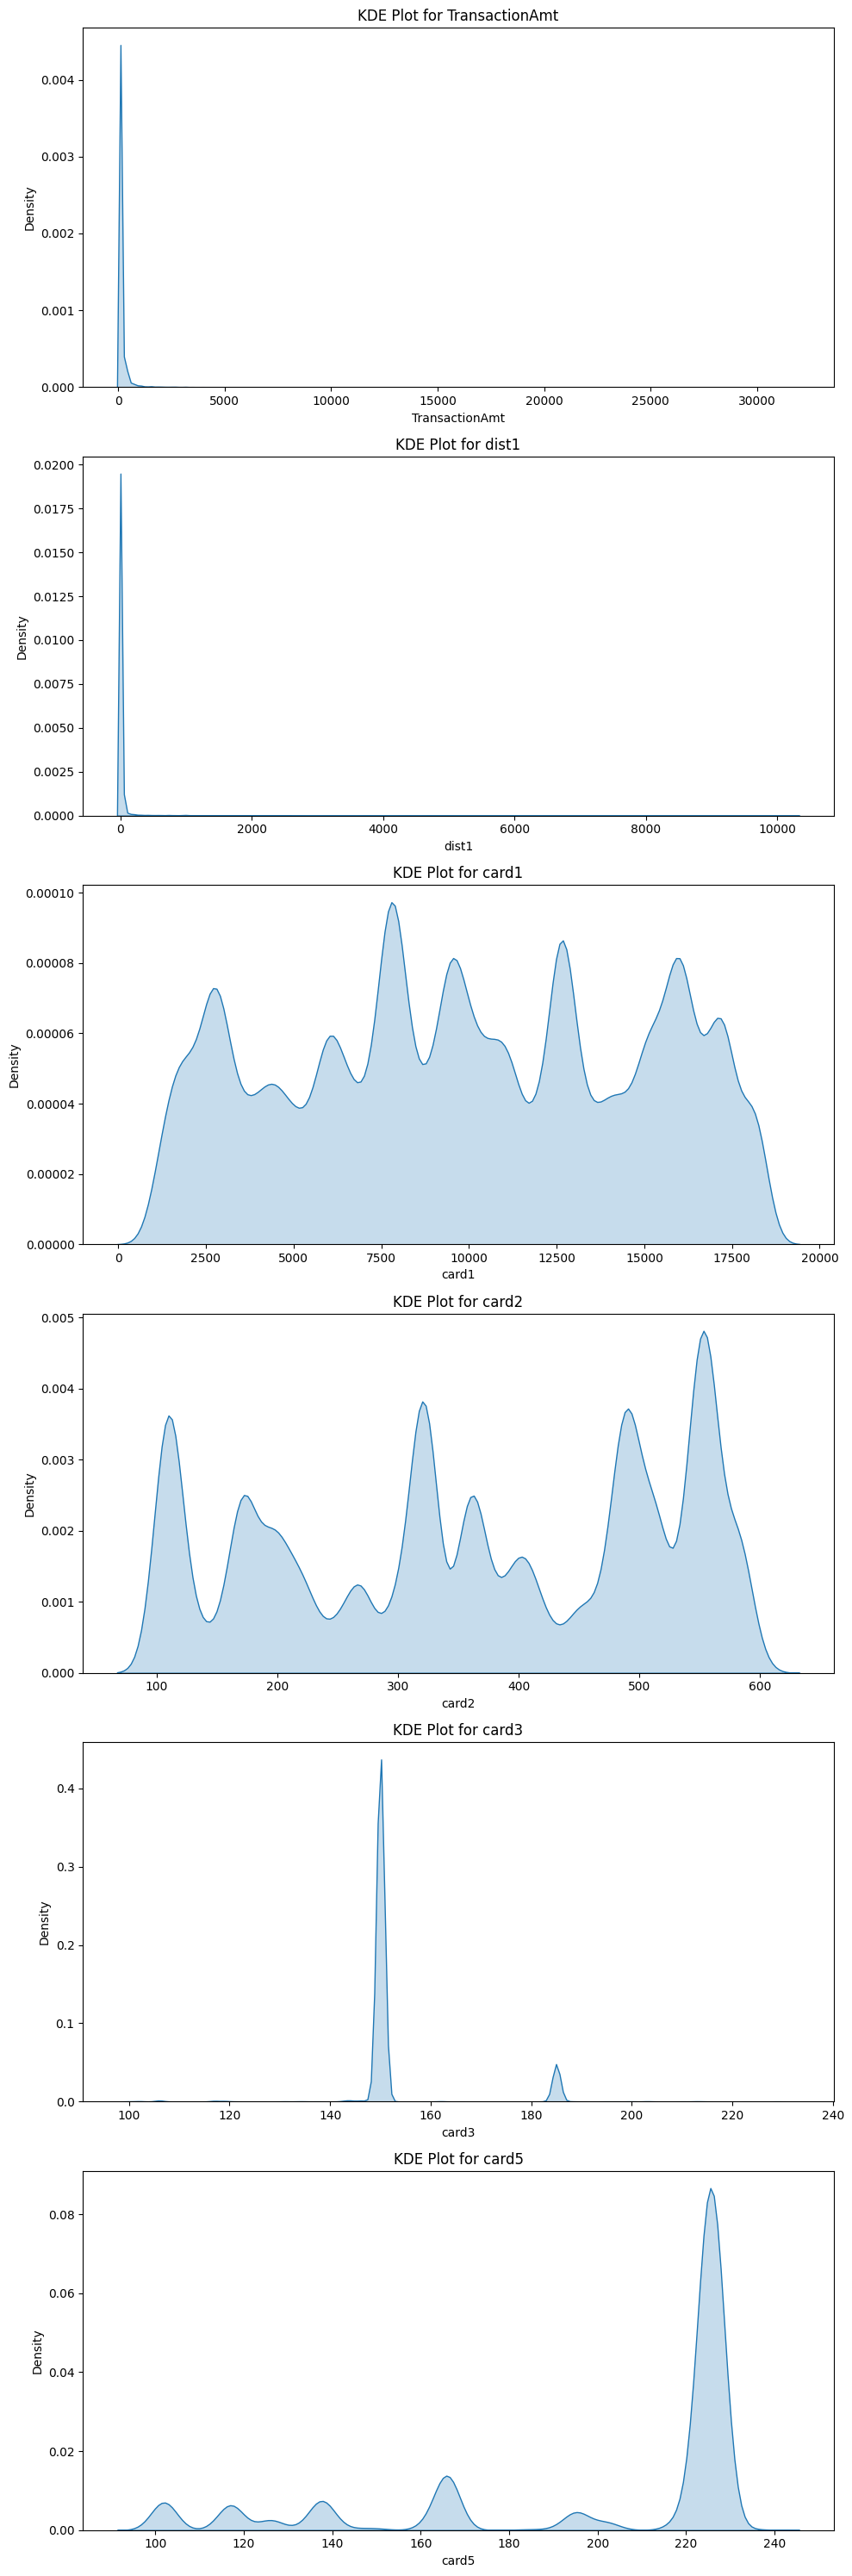

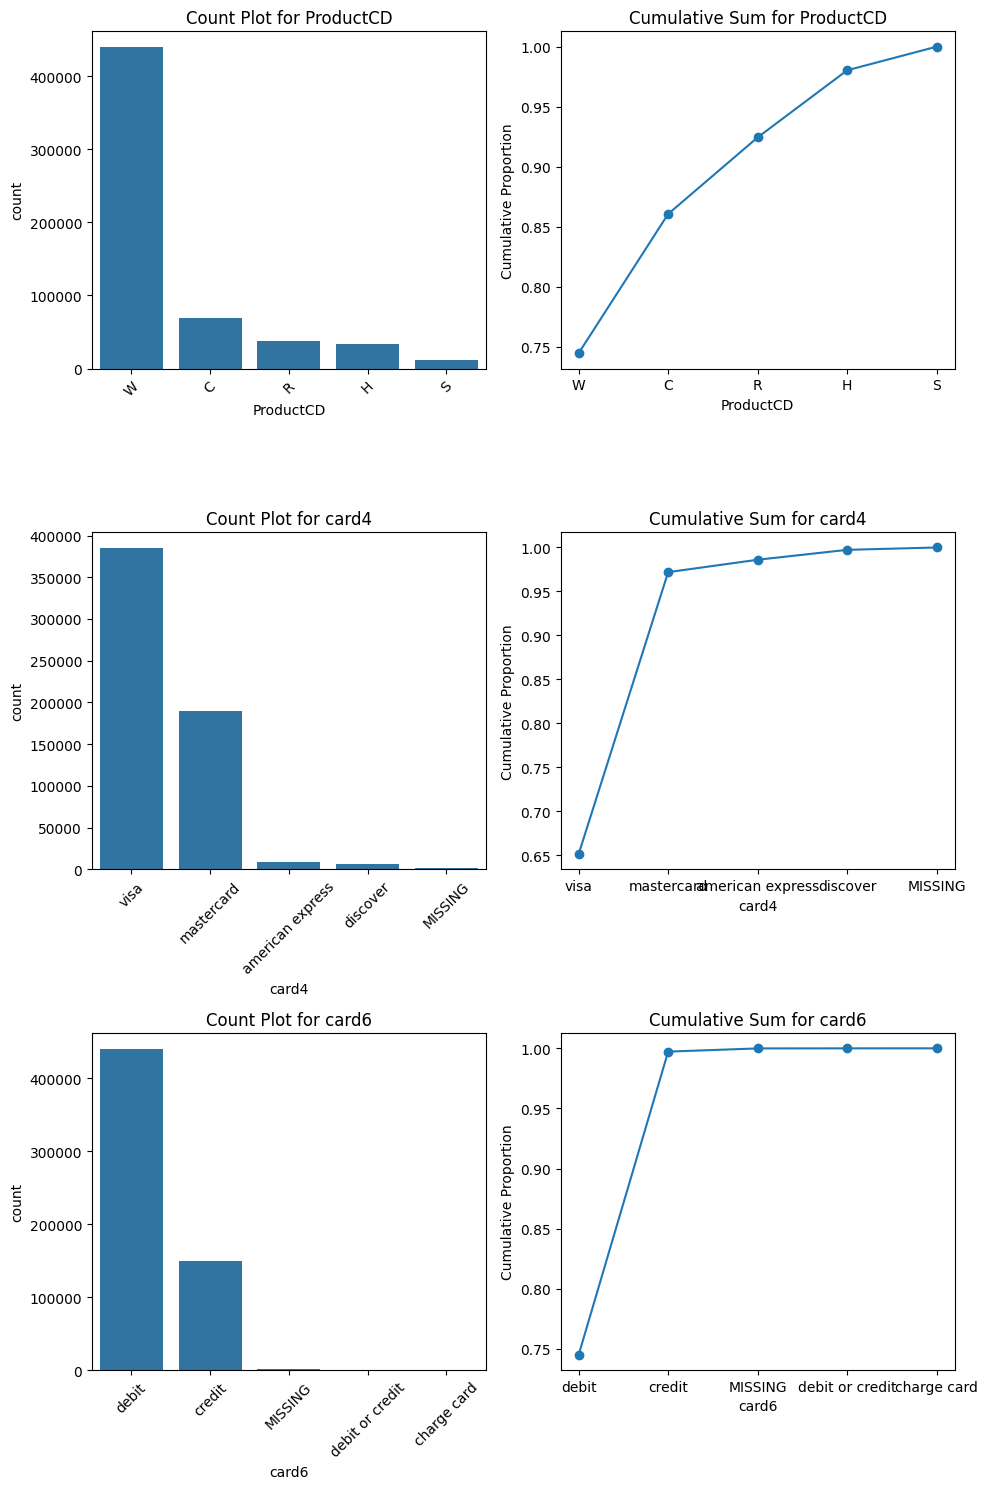

In [14]:
visualize_distributions(processed_df, ['TransactionAmt', 'dist1', 'card1', 'card2', 'card3', 'card5'], ['ProductCD', 'card4', 'card6'])

Results:
- The transaction amount and distance seem to be highly concentrated around a small range of values, which is reasonable for the majority of records
- `card3` and `card5` columns have the bi- and multi-modal distributions
- The rest of the features have either close to uniform distribution or tend to have larger proportion of data towards some small subset of values.

### Address Features

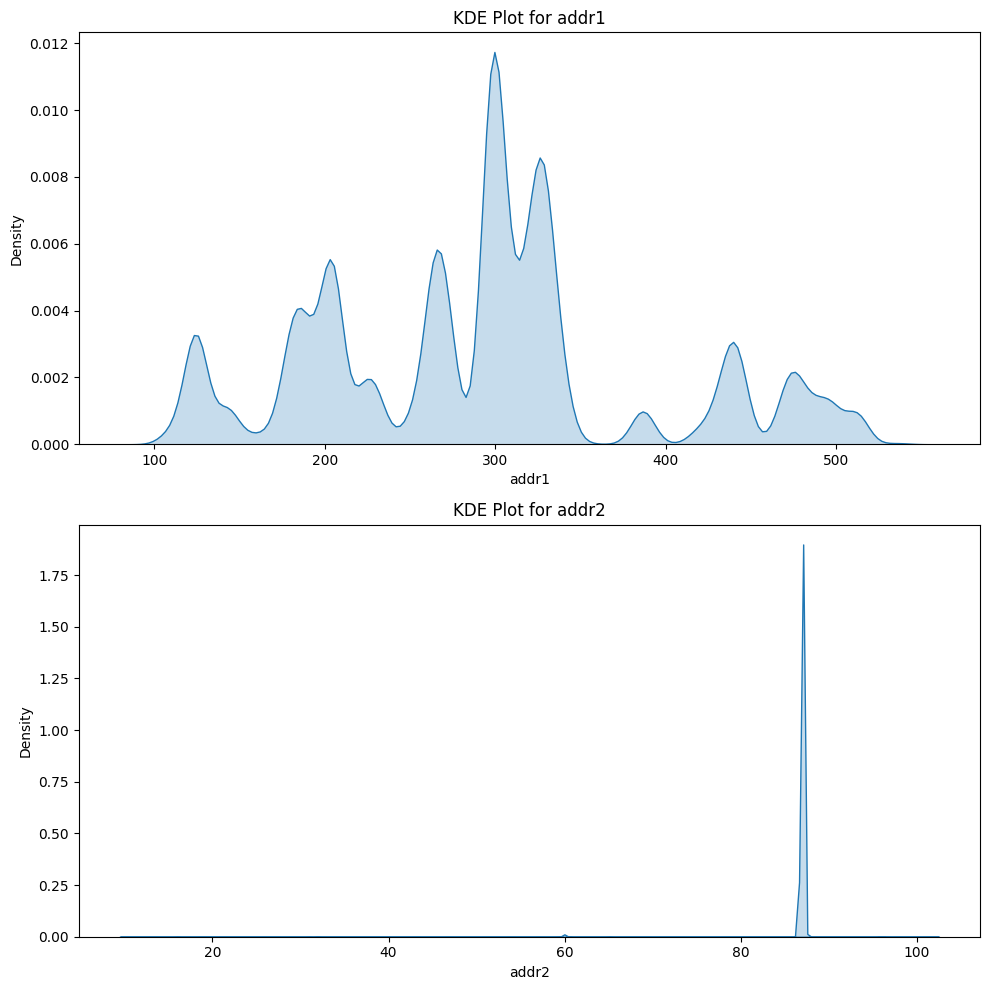

In [15]:
visualize_distributions(processed_df, ['addr1', 'addr2'])

(array([44., 11.,  6.,  3.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.,  0.,  1.,  0.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

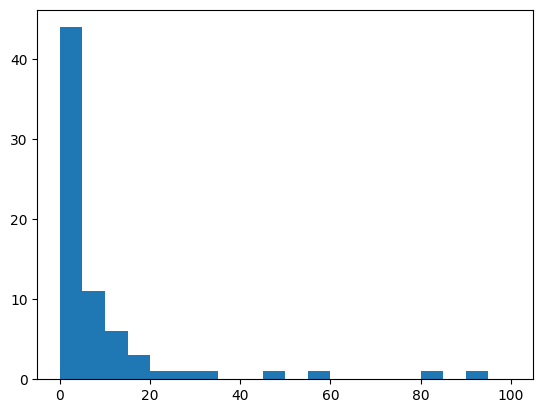

In [16]:
addr2 = processed_df.groupby('addr2').count()['TransactionID']
plt.hist(addr2, bins=20, range=(0.0, 100.0))

Resuls:
- Address 1 has multimodal distribution.
- Address 2 is highly concentrated around a small range of values, yet still preserving necessary information for the analysis.

### Email domains

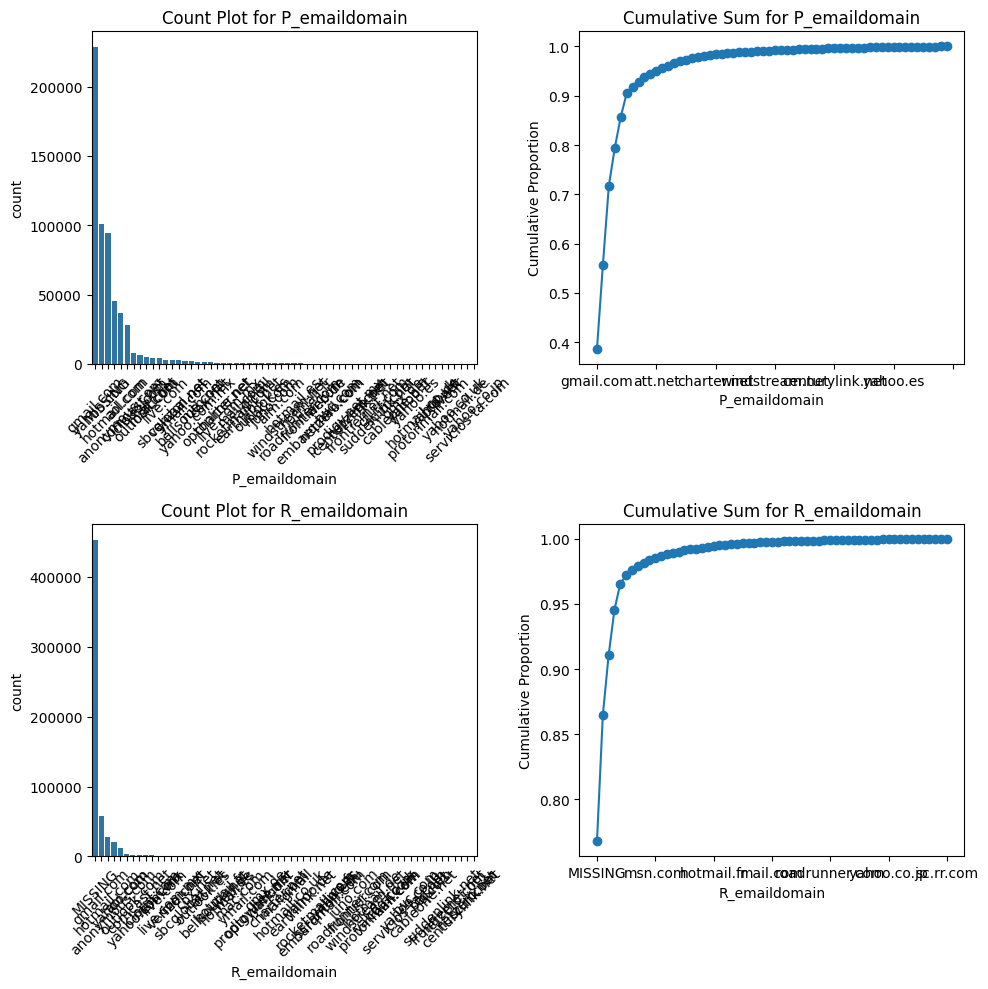

In [17]:
visualize_distributions(processed_df, [], ['P_emaildomain', 'R_emaildomain'])

### Study Email Columns

In [18]:
def visualize_fraud_impact_by_category(df, categorical_cols, selected_categories=None, target_col='isFraud'):
    """
    Visualize the impact of each category on the classification by showing how many rows
    with a feature having a category from the set of all categories has value 1 in the 'isFraud' column.

    Parameters:
        df (pd.DataFrame): The dataset.
        categorical_cols (list): List of categorical columns to analyze.
        target_col (str): The target column indicating fraud (default is 'isFraud').
    """
    for i, col in enumerate(categorical_cols):
        # Calculate the count of fraud (isFraud = 1) for each category
        if selected_categories is not None:
            filter_df = df[df[col].isin(selected_categories[i])]
        else:
            filter_df = df
        fraud_counts = filter_df[filter_df[target_col] == 1].groupby(col, observed=True).size()
        total_counts = filter_df.groupby(col, observed=True).size()

        # Calculate the proportion of fraud for each category
        fraud_proportion = (fraud_counts / total_counts)

        # Plot the results
        plt.figure(figsize=(10, 6))
        sns.barplot(x=fraud_proportion.index.to_list(), y=fraud_proportion.values)
        plt.title(f'Proportion of Fraud by {col}')
        plt.xlabel(col)
        plt.ylabel('Proportion of Fraud')
        plt.xticks(rotation=45)
        plt.show()

In [19]:
def visualize_category_counts(df, feature_name, selected_categories):
    """
    Visualize the number of appearances in the dataframe of rows with the category value of the feature.

    Parameters:
        df (pd.DataFrame): The dataset.
        feature_name (str): The name of the categorical feature to analyze.
        selected_categories (list): List of selected categories to visualize.
    """
    # Filter the dataframe to include only the selected categories
    filtered_df = df[df[feature_name].isin(selected_categories)]

    # Count the occurrences of each selected category
    category_counts = filtered_df[feature_name].value_counts().reindex(selected_categories, fill_value=0)

    # Plot the results
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
    plt.title(f'Count of Rows for Selected Categories in {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Count of Rows')
    plt.xticks(rotation=45)
    plt.show()

In [20]:
def categories_with_high_impact(df, categorical_col, rate, target_col='isFraud'):
    # Calculate the count of fraud (isFraud = 1) for each category
    fraud_counts = df[df[target_col] == 1].groupby(categorical_col, observed=False).size()
    total_counts = df.groupby(categorical_col, observed=False).size()

    # Calculate the proportion of fraud for each category
    fraud_proportion = (fraud_counts / total_counts).fillna(0)
    return fraud_proportion[fraud_proportion > rate].index

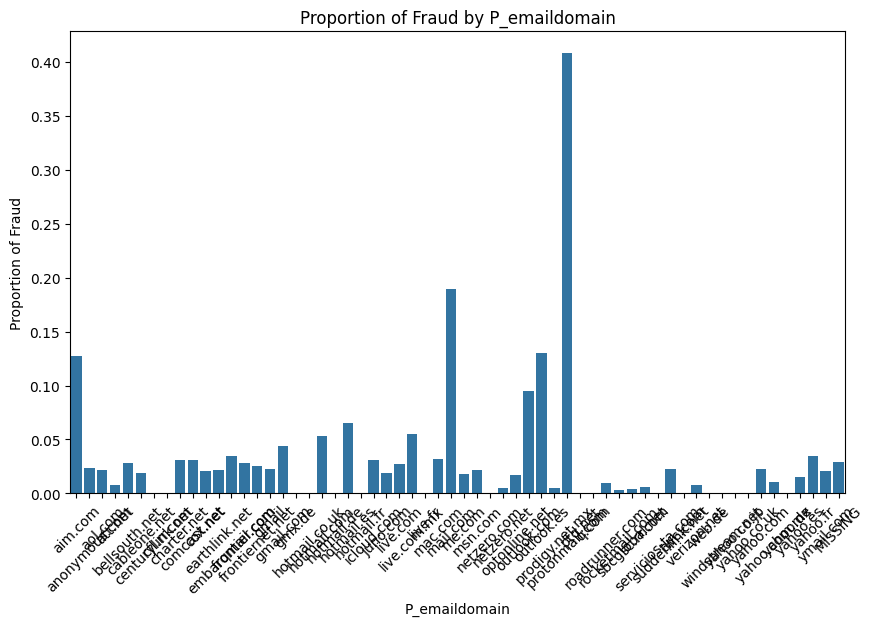

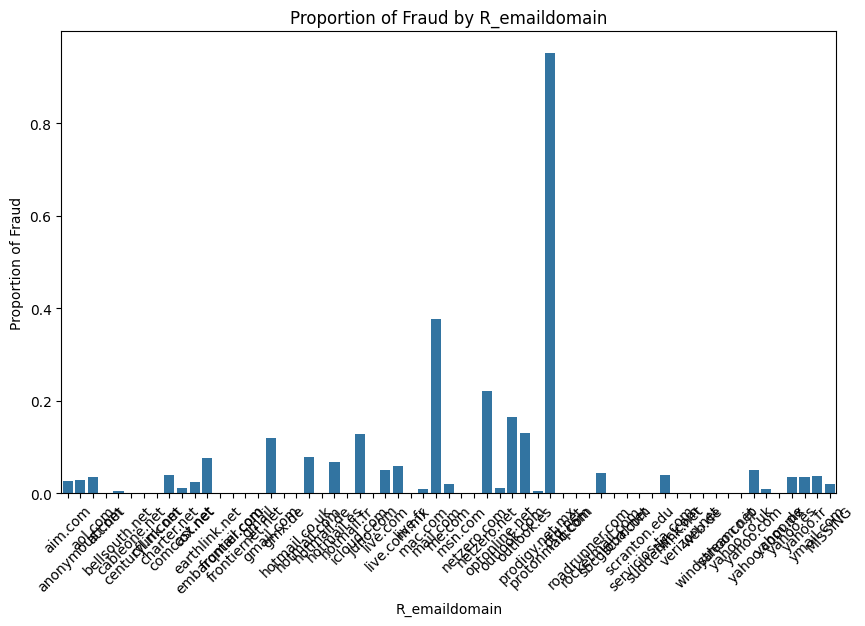

In [21]:
visualize_fraud_impact_by_category(processed_df, ['P_emaildomain', 'R_emaildomain'])

Determine categories with high proportion of fraudulent data (set the threshold level to be 5%)

In [22]:
p_domain_high_impact_categories = categories_with_high_impact(processed_df, 'P_emaildomain', 0.05)
p_domain_high_impact_categories.to_list()

['aim.com',
 'hotmail.com',
 'hotmail.es',
 'live.com.mx',
 'mail.com',
 'outlook.com',
 'outlook.es',
 'protonmail.com']

In [23]:
r_domain_high_impact_categories = categories_with_high_impact(processed_df, 'R_emaildomain', 0.05)
r_domain_high_impact_categories.to_list()

['earthlink.net',
 'gmail.com',
 'hotmail.com',
 'hotmail.es',
 'icloud.com',
 'live.com.mx',
 'mail.com',
 'netzero.net',
 'outlook.com',
 'outlook.es',
 'protonmail.com',
 'yahoo.com']

Visualization of domains with high proportion of fradulent data

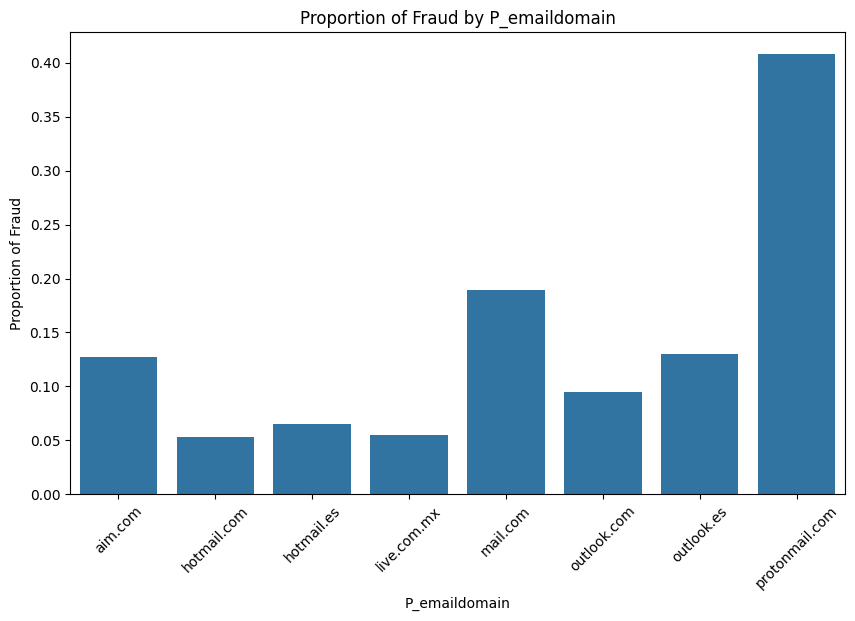

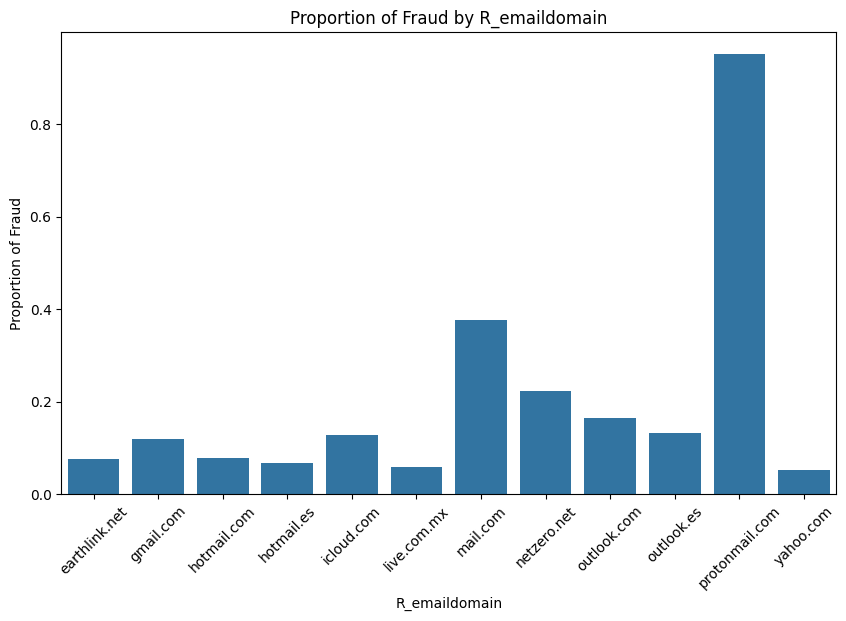

In [24]:
visualize_fraud_impact_by_category(processed_df, ['P_emaildomain', 'R_emaildomain'], [p_domain_high_impact_categories.to_list(), r_domain_high_impact_categories.to_list()])

In addition to the observed impact of different domains, let's look at the distribution of domains across the dataset

<ipython-input-19-983874c249eb>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


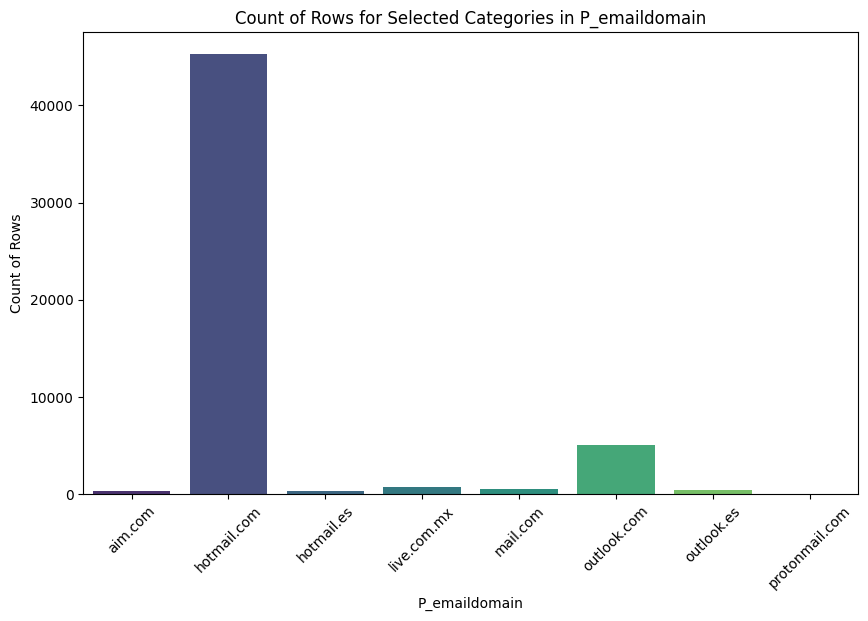

In [25]:
visualize_category_counts(processed_df, 'P_emaildomain', p_domain_high_impact_categories.to_list())

<ipython-input-19-983874c249eb>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


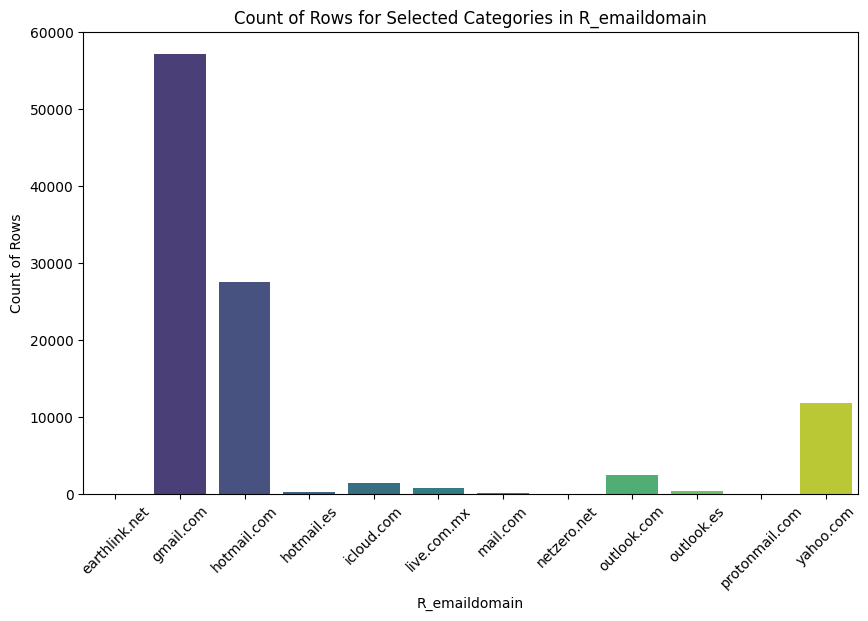

In [26]:
visualize_category_counts(processed_df, 'R_emaildomain', r_domain_high_impact_categories.to_list())

Results:
  - The dataset suggests that transaction made from or to `protonemail.com` domain is highly likely to be fraudulent. Moreover, the small number of usages of such domain suggests that this type of email is outlier compared to the rest of the data. Therefore, such email domain has a large impact of a transaction to be considered fraudulent.
  - Additionally, a group of email domains highly correlated with the fraud transactions is considered for further encoding.

### Transform Email Columns

In [27]:
p_groups = set(p_domain_high_impact_categories)
r_groups = set(r_domain_high_impact_categories)

# Create a function to apply the encoding rules
def encode_domain(email, groups):
    if email == 'protonmail.com':
        return 2
    elif email in groups:
        return 1
    else:
        return 0

# Apply the encoding to 'P_emaildomain' and 'R_emaildomain'
processed_df['P_emaildomain'] = processed_df.apply(
    lambda row: encode_domain(row['P_emaildomain'], p_groups),
    axis=1
)
processed_df['R_emaildomain'] = processed_df.apply(
    lambda row: encode_domain(row['R_emaildomain'], r_groups),
    axis=1
)

### M columns

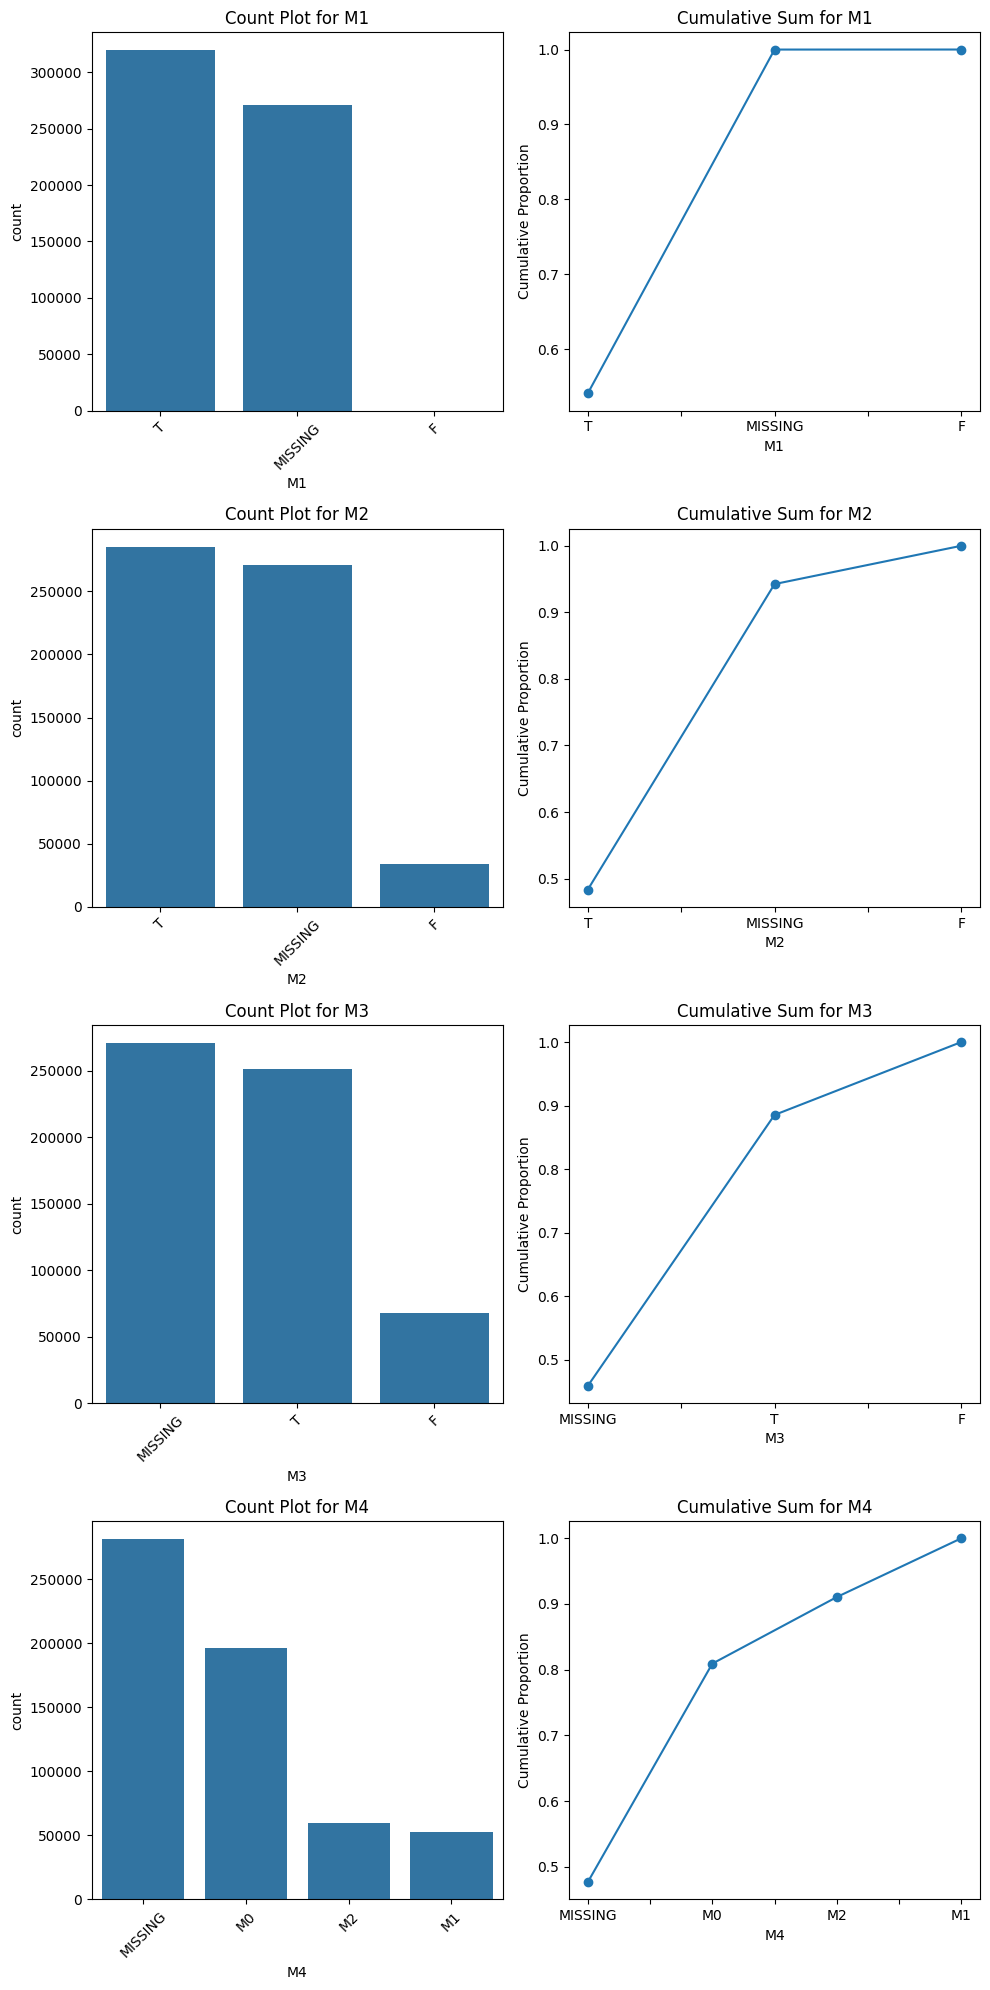

In [28]:
visualize_distributions(processed_df, [], ['M1', 'M2', 'M3', 'M4'])

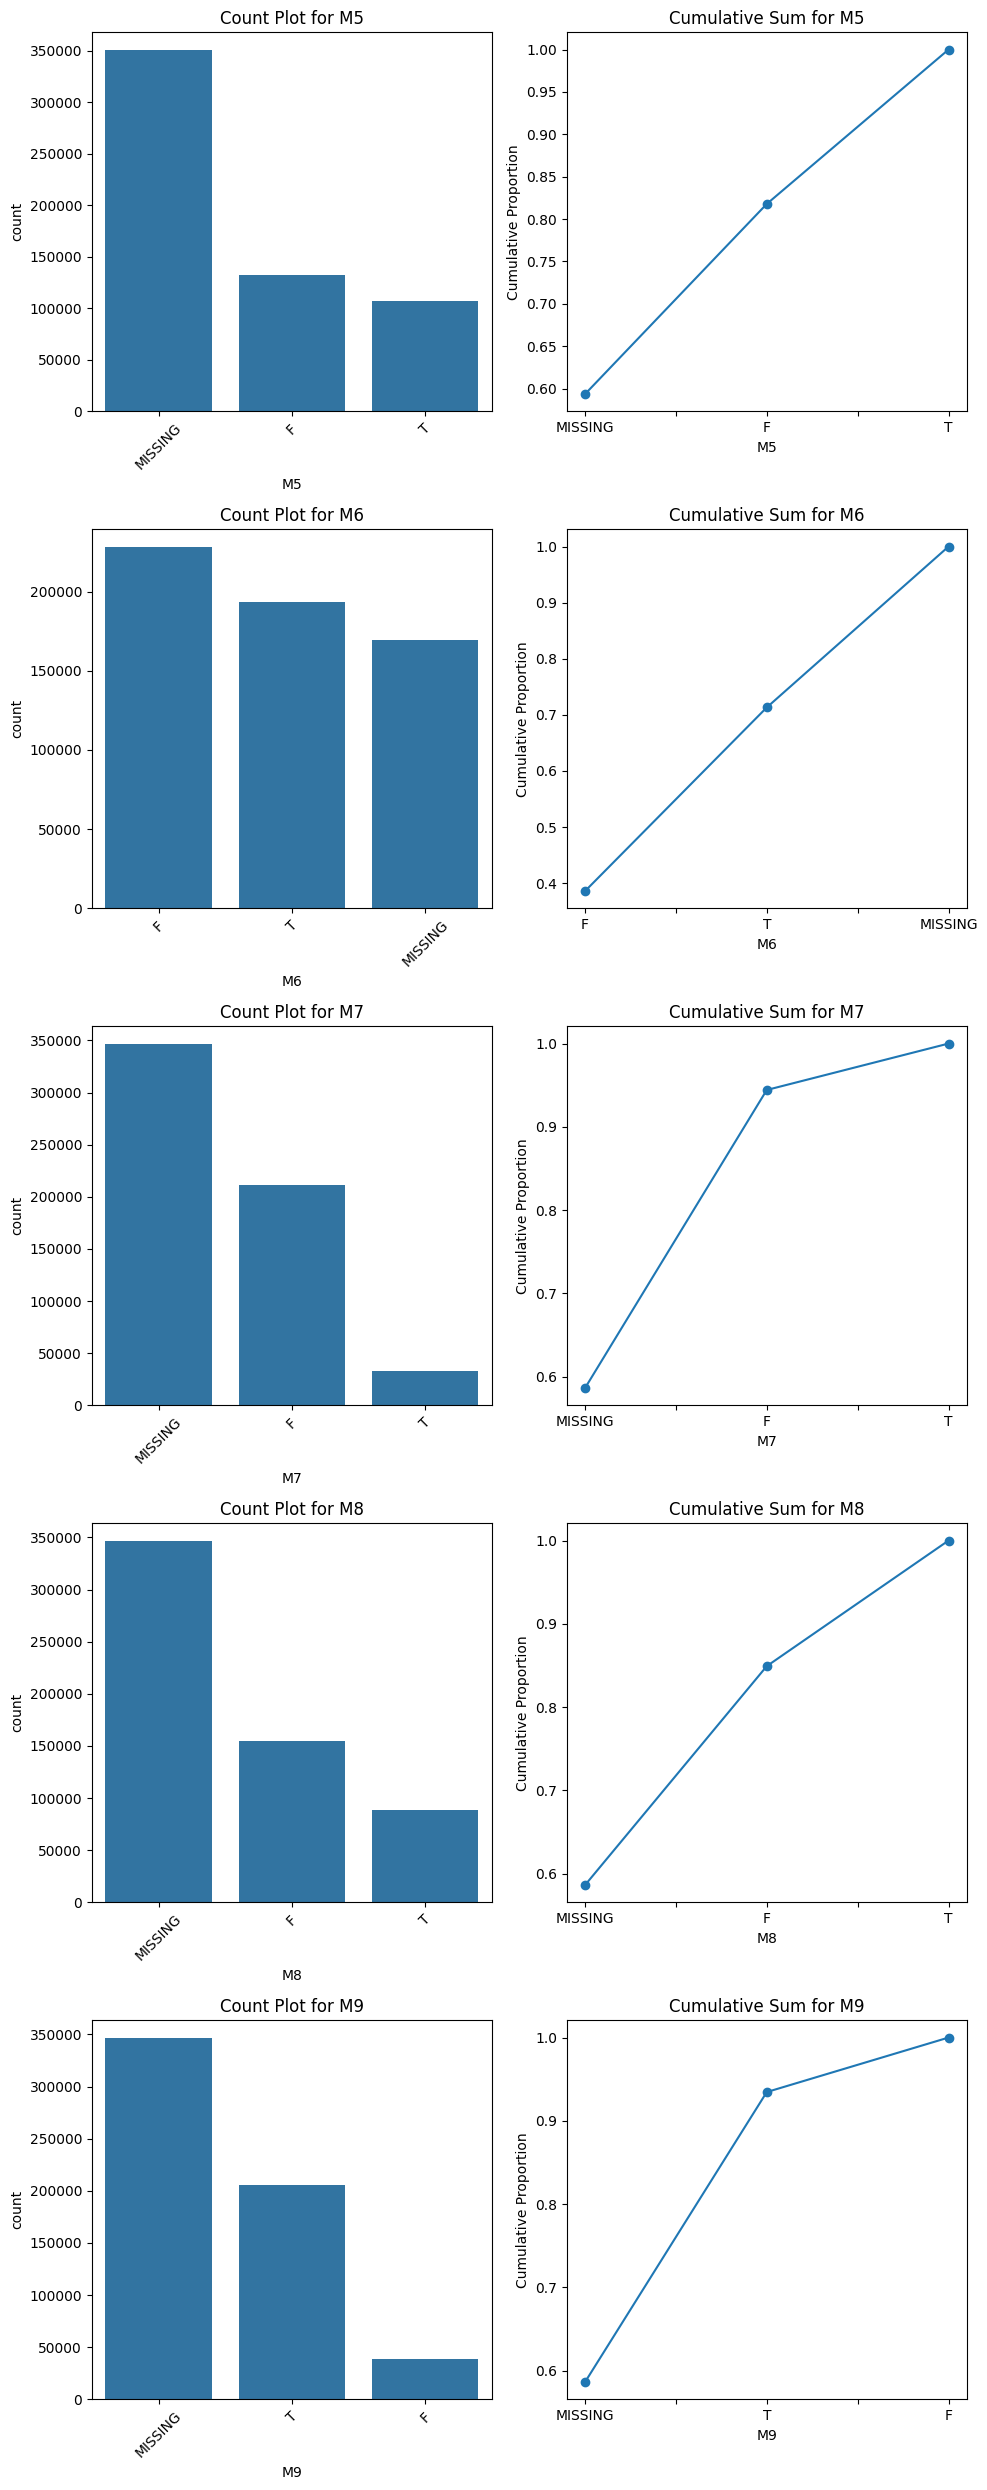

In [29]:
visualize_distributions(processed_df, [], ['M5', 'M6', 'M7', 'M8', 'M9'])

Results:
- The dataset description noted that false values for this type of columns indicate some abnormal behavior. Therefore, the encoding of this feature is performed as follows: 2 is assigned for false values, 1 for missing (possible false), and 0 for true.

In [30]:
# Create a function to apply the encoding rules
def encode_match(value):
    if value == 'F':
        return 2
    elif value == 'MISSING':
        return 1
    else:
        return 0

for m in range(1, 10):
    if m == 4:
        continue
    column_name = f"M{m}"

    processed_df[column_name] = processed_df.apply(
        lambda row: encode_match(row[column_name]),
        axis=1
    )

### Vesta engineered rich features

Unfortunately, due to the lack of description for such features, no domain knowledge can be performed for preprocessing. Thus, we leverage the work for selection for the next step: GA feature selection.

In [31]:
len([name for name in processed_df.columns if name.startswith('V')])

292

### Identity Information

Distribution view of `DeviceType`

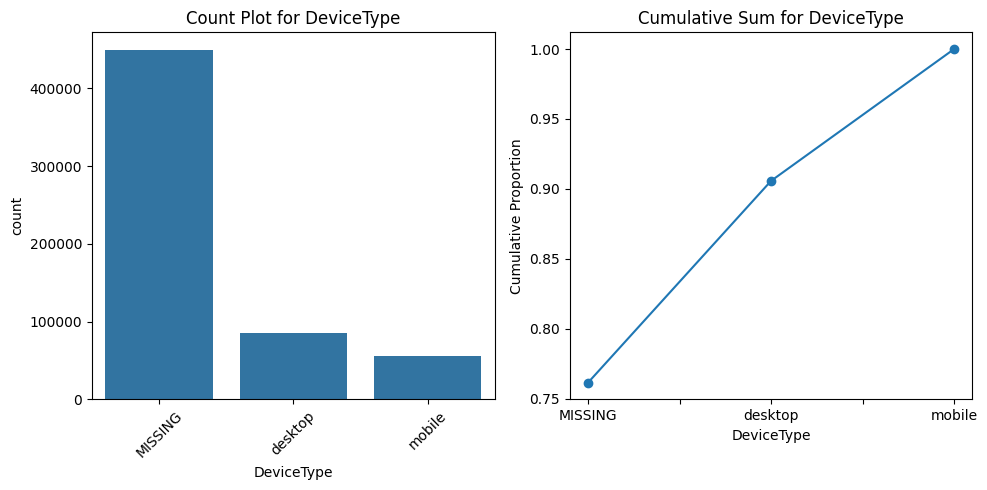

In [32]:
visualize_distributions(processed_df, [], ['DeviceType'])

Correlation with fraud transactions of `DeviceType`

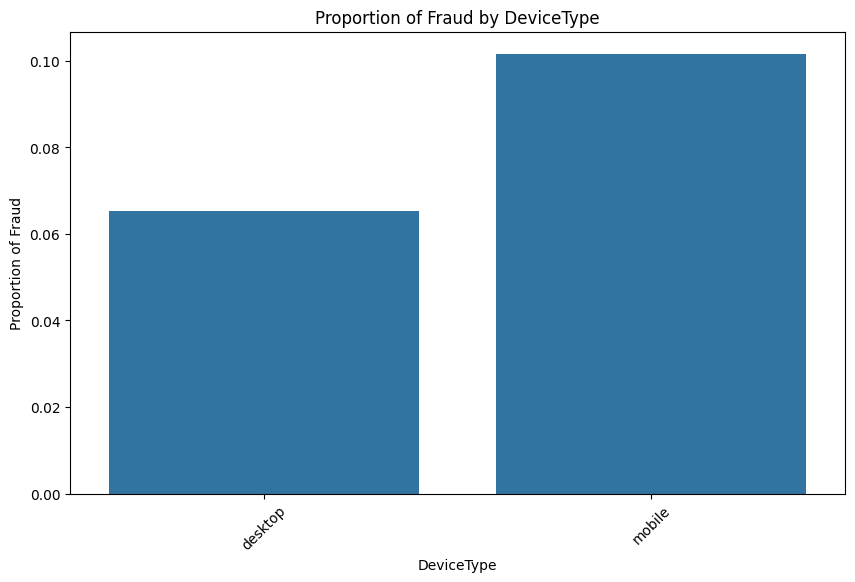

In [33]:
visualize_fraud_impact_by_category(processed_df, ['DeviceType'], [['desktop', 'mobile']])

Results for `DeviceType`:
- Since the impact of each device type is not negligible, and there are only two types, the one-hot encoding will be performed at a later stage.

Distribution view of `DeviceInfo`

The missing rate analysis and the distribution of the number of values with the same category from `DeviceInfo`

<ipython-input-34-93df8e59ed7b>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  info_counts = processed_df.groupby('DeviceInfo').count()['TransactionID']


Missing proportion: 0.7990551021099332


(array([440., 341., 237., 147., 108.,  64.,  46.,  30.,  34.,  28.,  27.,
         20.,  18.,  12.,  19.,   5.,  12.,   6.,  11.,   6.,   3.,   7.,
          9.,   7.,   2.,   7.,   4.,   2.,   4.,   6.,  11.,   3.,   5.,
          6.,   3.,   3.,   2.,   2.,   3.,   0.,   2.,   2.,   3.,   2.,
          4.,   3.,   2.,   2.,   2.,   1.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100.]),
 <BarContainer object of 50 artists>)

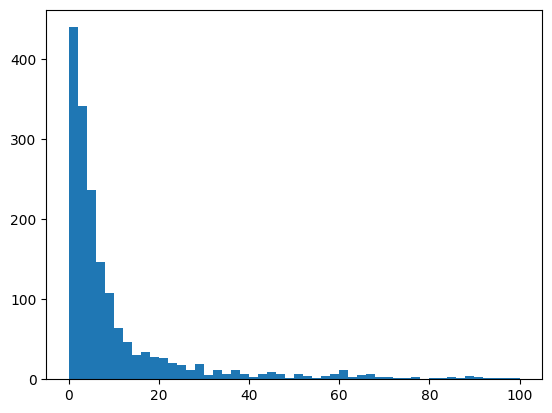

In [34]:
info_counts = processed_df.groupby('DeviceInfo').count()['TransactionID']
print(f"Missing proportion: {info_counts['MISSING'] / info_counts.sum()}")
plt.hist(info_counts.values, bins=50, range=(0.0, 100.0))

Results for `DeviceInfo`:
- Since the rate of missing is almost 80%, and most of the categories have a small number of records, the feature can be omitted.

### ID columns

In [35]:
print([name for name in processed_df.columns if name.startswith('id')])

['id_01', 'id_02', 'id_05', 'id_06', 'id_11', 'id_12', 'id_13', 'id_15', 'id_16', 'id_17', 'id_19', 'id_20', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37', 'id_38']


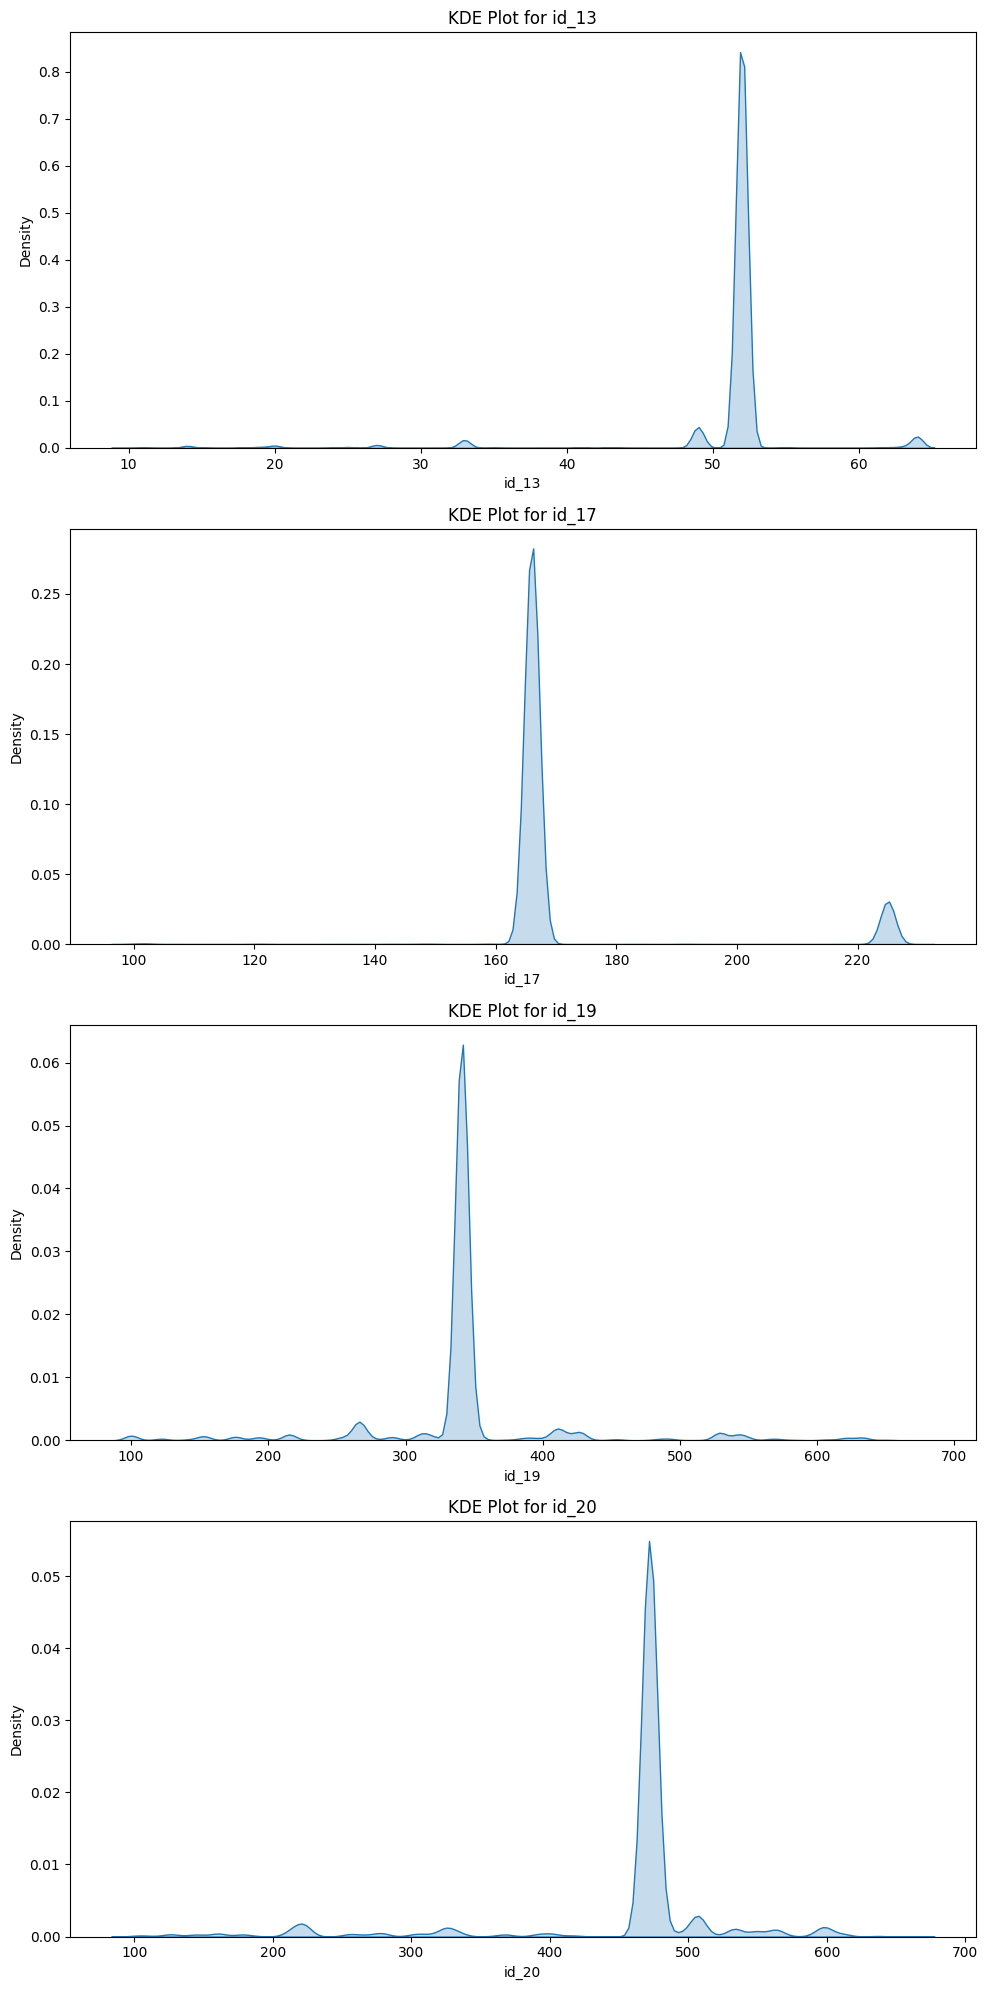

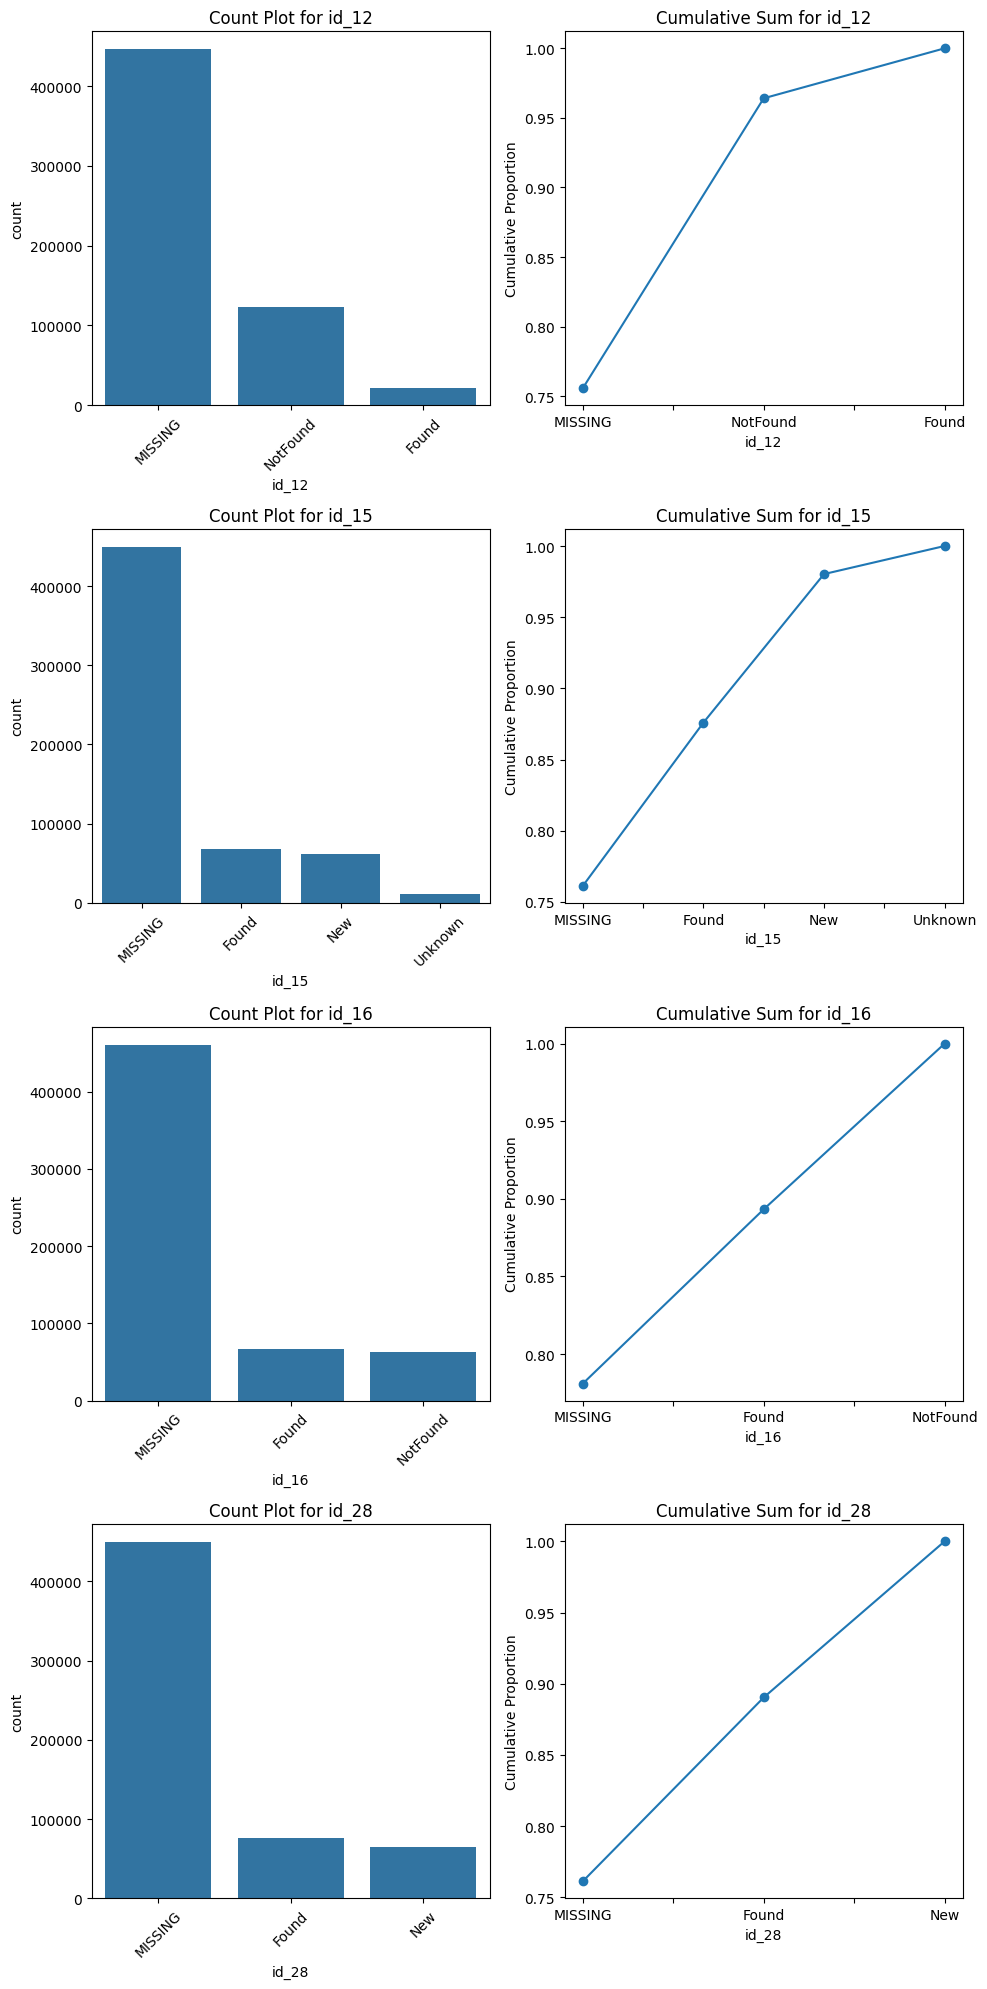

In [36]:
visualize_distributions(processed_df, ['id_13', 'id_17', 'id_19', 'id_20'], ['id_12', 'id_15', 'id_16', 'id_28'])

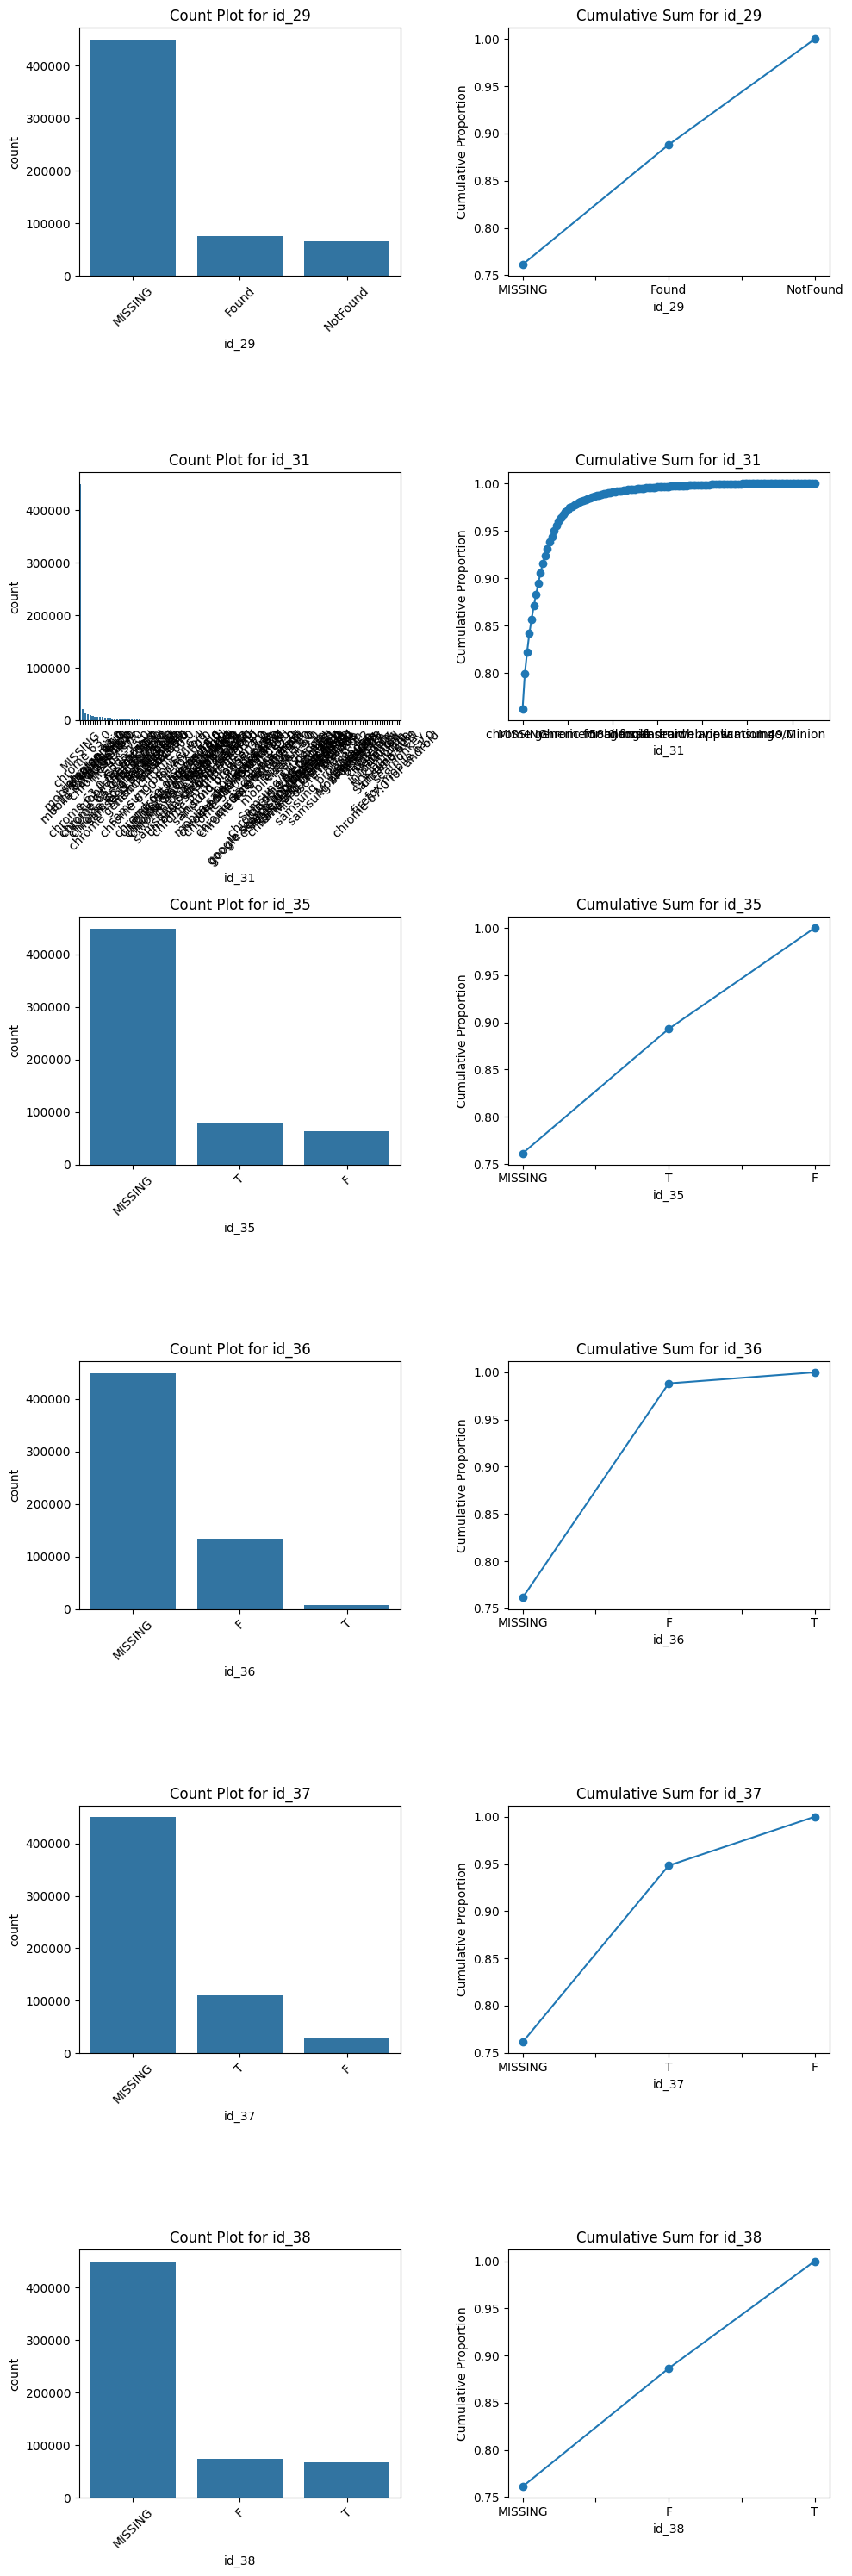

In [37]:
visualize_distributions(processed_df, [], ['id_29', 'id_31', 'id_35', 'id_36', 'id_37', 'id_38'])

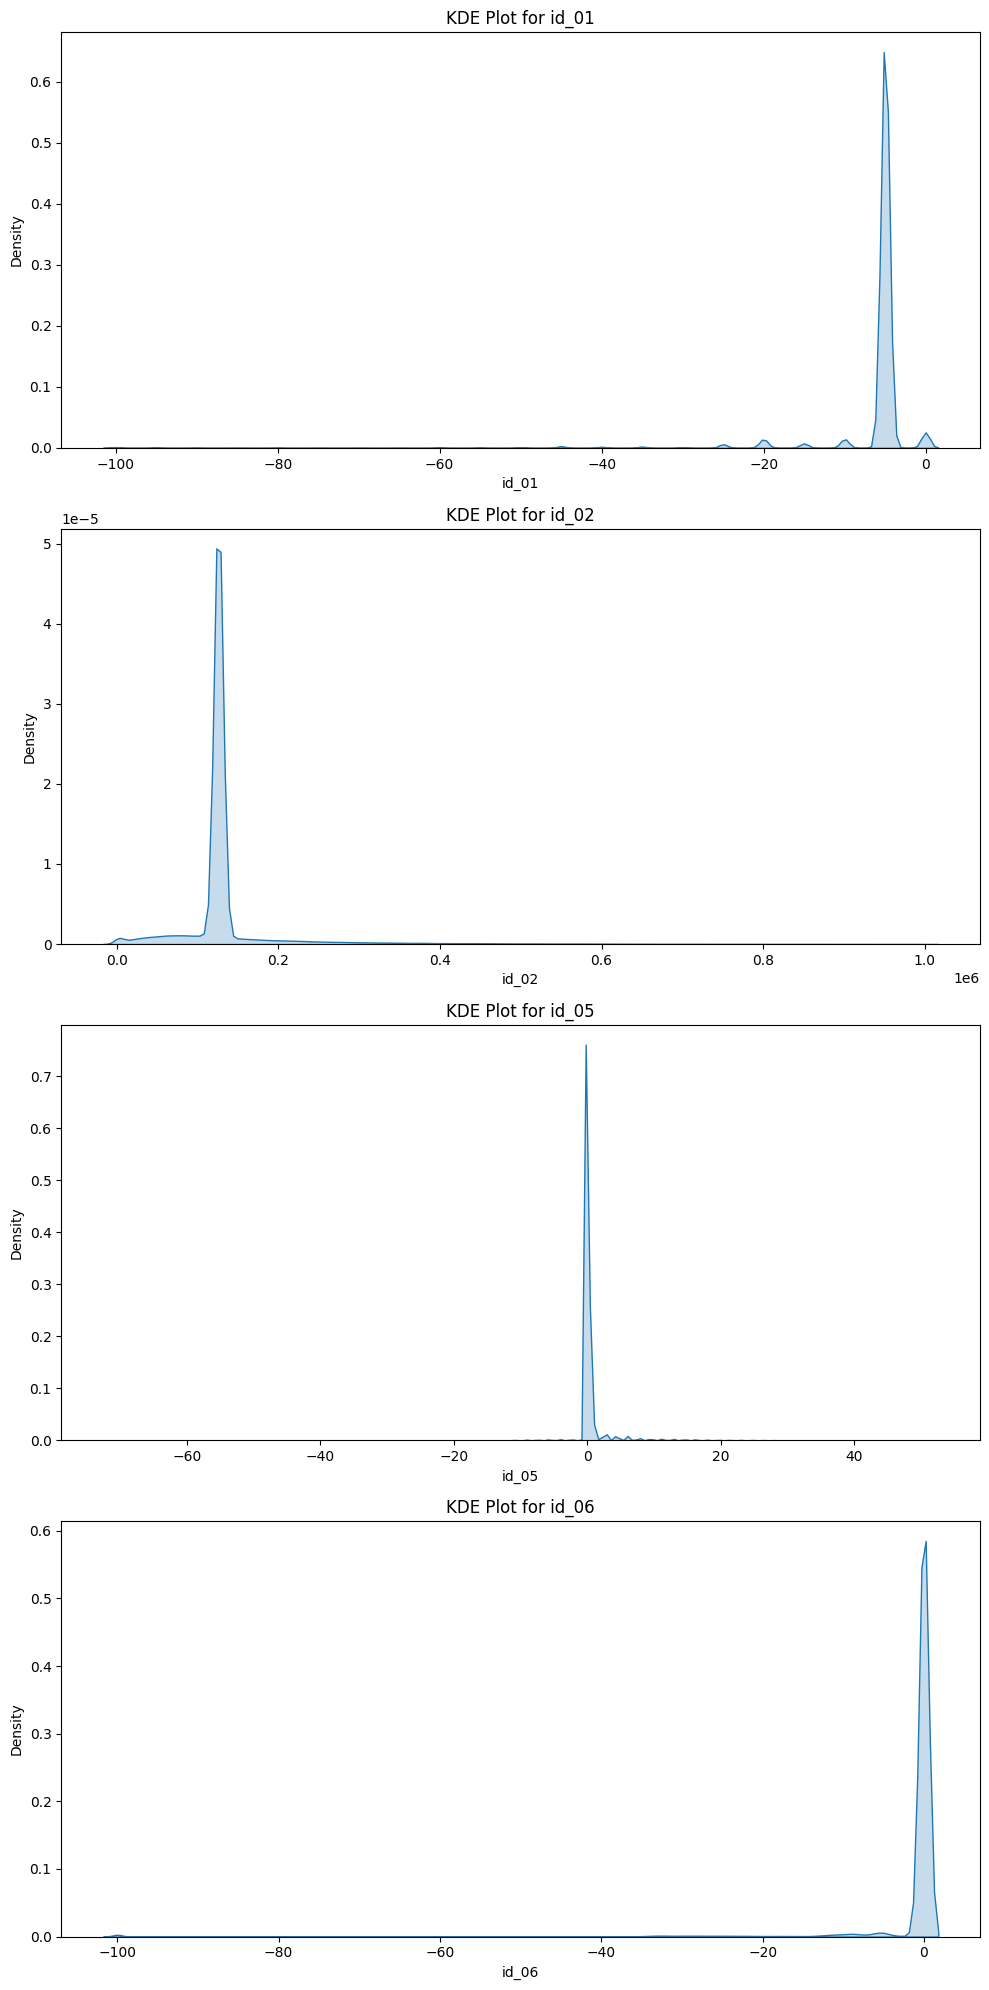

In [38]:
visualize_distributions(processed_df, ['id_01', 'id_02', 'id_05', 'id_06'], [])

Observations from the distribution analysis:
1. Continous data is mostly unimodal or bimodal.
2. Most of the categorical features have two category values with approximately equal distribution.
3. `id31` column has significanly large number of categories with small proportion of each category itself.

The missing rate analysis and the distribution of the number of values with the same category from `id31`

<ipython-input-39-5c422a581b2a>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  browser_counts = processed_df.groupby('id_31').count()['TransactionID']


Missing proportion: 0.7624513157449114


(array([92., 11.,  5.,  3.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  3.,  0.,
         1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([    0.,   300.,   600.,   900.,  1200.,  1500.,  1800.,  2100.,
         2400.,  2700.,  3000.,  3300.,  3600.,  3900.,  4200.,  4500.,
         4800.,  5100.,  5400.,  5700.,  6000.,  6300.,  6600.,  6900.,
         7200.,  7500.,  7800.,  8100.,  8400.,  8700.,  9000.,  9300.,
         9600.,  9900., 10200., 10500., 10800., 11100., 11400., 11700.,
        12000., 12300., 12600., 12900., 13200., 13500., 13800., 14100.,
  

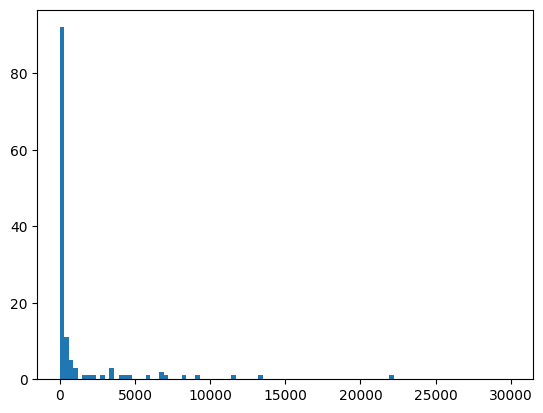

In [39]:
browser_counts = processed_df.groupby('id_31').count()['TransactionID']
print(f"Missing proportion: {browser_counts['MISSING'] / browser_counts.sum()}")
plt.hist(browser_counts.values, bins=100, range=(0.0, 30000.0))

Results for `id31`:
- Since the rate of missing is more than 75%, and most of the categories have a small number of records, the feature can be omitted.

### Remove redundant features

In [40]:
redundant_features.append('DeviceInfo') # sparse and rare categories with >70% missing rate
redundant_features.append('id_31')  # sparse and rare categories with >70% missing rate

In [41]:
processed_df = processed_df.drop(columns=redundant_features)

The remaining categorical features

In [42]:
processed_df.select_dtypes(include=['category', 'object']).columns.tolist()

['ProductCD',
 'card4',
 'card6',
 'M4',
 'id_12',
 'id_15',
 'id_16',
 'id_28',
 'id_29',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType']

### Saving the results

In [43]:
# Save in efficient binary format
processed_df.to_parquet('explored_fraud_data.parquet', index=False)

## Encoding rest of categorical features

In [44]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.sparse import csr_matrix

def handle_categorical_data(input_path, output_path, threshold=0.05):
    """
    One-Hot Encoding of categorical features
    """
    # Data loading
    df = pd.read_parquet(input_path)

    # Categorical features selection
    categorical_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()

    # Rare categories filtration
    for col in categorical_cols:
        if df[col].nunique() > 100:
            df[col] = df[col].astype('category').cat.add_categories(['RARE_CATEGORY'])
            counts = df[col].value_counts(normalize=True)
            mask = df[col].isin(counts[counts < threshold].index)
            df.loc[mask, col] = 'RARE_CATEGORY'
            df[col] = df[col].cat.remove_unused_categories()

    # OneHotEncoder initialization with sparsed output
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(
                handle_unknown='ignore',
                sparse_output=True  # For sklearn >= 1.2 use sparse_output
            ), categorical_cols)
        ],
        remainder='passthrough'
    )

    transformed_data = preprocessor.fit_transform(df)

    # DataFrame creation
    encoded_df = pd.DataFrame(
        transformed_data,
        columns=preprocessor.get_feature_names_out()
    ).astype('float32')  # Memory optimisation

    # Saving
    encoded_df.to_parquet(output_path, index=False)
    return encoded_df

In [45]:
handle_categorical_data(
    input_path='explored_fraud_data.parquet',
    output_path='encoded_fraud_data.parquet',
    threshold=0.03
)

,cat__ProductCD_C,cat__ProductCD_H,cat__ProductCD_R,cat__ProductCD_S,cat__ProductCD_W,cat__card4_MISSING,cat__card4_american express,cat__card4_discover,cat__card4_mastercard,cat__card4_visa,...,remainder__V321,remainder__id_01,remainder__id_02,remainder__id_05,remainder__id_06,remainder__id_11,remainder__id_13,remainder__id_17,remainder__id_19,remainder__id_20
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.000000,-5.0,125800.5,0.0,0.0,100.0,52.0,166.0,341.0,472.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,-5.0,125800.5,0.0,0.0,100.0,52.0,166.0,341.0,472.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,-5.0,125800.5,0.0,0.0,100.0,52.0,166.0,341.0,472.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,-5.0,125800.5,0.0,0.0,100.0,52.0,166.0,341.0,472.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.0,70787.0,0.0,0.0,100.0,52.0,166.0,542.0,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,-5.0,125800.5,0.0,0.0,100.0,52.0,166.0,341.0,472.0
590536,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,-5.0,125800.5,0.0,0.0,100.0,52.0,166.0,341.0,472.0
590537,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,-5.0,125800.5,0.0,0.0,100.0,52.0,166.0,341.0,472.0
590538,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,-5.0,125800.5,0.0,0.0,100.0,52.0,166.0,341.0,472.0


## Normalization of features

In [50]:
from sklearn.preprocessing import MinMaxScaler


def normalize(input_path, output_path):
    """
    Normalization of the dataset
    """
    # Data loading
    df = pd.read_parquet(input_path)
    columns = df.columns

    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(df)
    # DataFrame creation
    scaled_df = pd.DataFrame(
        scaled_values,
        columns=columns
    ).astype('float32')  # Memory optimisation

    # Saving
    scaled_df.to_parquet(output_path, index=False)
    return scaled_df

In [52]:
df = normalize(
    input_path='encoded_fraud_data.parquet',
    output_path='fraud_data.parquet'
)

### Conclusion

The preliminary data exploration and preprocessing resulted in removing redundant features and preparing the dataset for future model training.

The remaining number of features is 393.

In [57]:
df[df['remainder__isFraud']==1].size / df.size

0.03499000914417313

However, the dataset contains 590,000 records with only around 3,5% being fraudulent. This fact suggests that the dataset is highly imbalanced, and some balancing is needed, which is accounted in the model pipeline design.